<a href="https://colab.research.google.com/github/Rogerx98/twsm-group-project/blob/main/SentenceBERT_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Comment:

Inspiration 1 for Multi-label: https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb

Inspiration 2 for MultiLabelBinarizer = https://github.com/pnageshkar/NLP/blob/master/Medium/Multi_label_Classification_BERT_Lightning.ipynb

# **Libraries**

In [140]:
!pip install transformers 
!pip install bs4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [141]:
import pandas as pd
import numpy as np
import re

# Huggingface transformers
import transformers
from transformers import BertModel,BertTokenizer,AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn ,cuda
from torch.utils.data import DataLoader,Dataset,RandomSampler, SequentialSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import MultiLabelBinarizer

from bs4 import BeautifulSoup

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import BertForSequenceClassification

import tensorflow as tf

np.set_printoptions(formatter={'float_kind':'{:f}'.format})
#since most of our numbers will be decimals :)

In [142]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Dataset**

In [143]:
df = pd.read_csv("/content/drive/Othercomputers/Mi portátil/Master/GitHub/twsm-group-project/twsm_project_corpus0.csv")
#df = pd.read_csv("/content/drive/MyDrive/twsm/twsm_project_corpus0.csv", index_col = 0) #valentins drive
#df = pd.read_csv("/home/valentin_werner/TWSM_Lab_Team4/twsm_project_corpus0.csv", index_col = 0) on zeno
df.head(5)
df = df.dropna() #drop na values (somehow a few remained in the dataset)
rejoined = [row.split(" ") for row in df.labels_str]
df["accept"] = rejoined
df.head(10)

,Unnamed: 0,text,accept,labels_str
0,0,The other part of our data consists of an undirected social graph.,[Data],Data
1,1,This list of actors can be interpreted to represent the most important barriers to successful software development in Nigeria.,[Definition],Definition
2,2,"The two samples were compared on all study variables and on age, gender, position, and organizational tenure.","[Method, Theory]",Method Theory
3,3,"This is supported by a more recent report by START_CITE West and Curtis (2006) END_CITE CITE_b72 , which found significant differences between women and men academics, including disparities in tenure and salaries.",[RelationToLiterature],RelationToLiterature
4,4,", the false noise parameter C was misstated by 0.10 (either all high or all low in a run) except near the end points (C = 0 or 1).",[Definition],Definition
5,5,"In the strategic management literature, the nature of the risk/return relationship was found to be contingent on a number of factors, all subject to managerial discretion: prior firm performance START_CITE (Fiegenbaum and Thomas, 1986; END_CITE CITE_b18 START_CITE Chang and Thomas, 1989) END_CITE CITE_b13 , diversification pattern START_CITE (Bettis, 1981; END_CITE CITE_b5 START_CITE Bettis and Mahajan, 1985) END_CITE CITE_b6 , industry membership START_CITE (Bowman, 1980; END_CITE CITE_b9 START_CITE Bettis and Mahajan, 1985) END_CITE CITE_b6 , strategic focus and decision discretion START_CITE (Jemison, 1987) END_CITE CITE_b22 or firm structure START_CITE (Hoskisson, 1987) END_CITE CITE_b21 .",[RelationToLiterature],RelationToLiterature
6,6,"No such link was found however, but, according to one of our con-tacts at KLM Cargo, the expectation is that this will be dealt with in the near future.",[FutureWork],FutureWork
7,7,"The problem is that the timeliness of the data and the speed at which they arrive can also, like data volume and variety, operate to increase the perceived complexity of knowledge generated from such data, enhance perceived effort to share such knowledge, and increase expected inability to cater to one's own needs.","[Data, Limitation]",Data Limitation
8,8,The social sciences differ from the physical sciences in that the validity of research depends significantly on its context.,[RelationToLiterature],RelationToLiterature
9,9,Browne et al. START_CITE [3] END_CITE CITE_b2 explain the development of CIM as the eulmination of a long and ongoing effort in the application of automation in the manufacture of discrete parts.,[RelationToLiterature],RelationToLiterature


## **Preprocess Text**

In [144]:
#@title
def pre_process(text):
  text = BeautifulSoup(text).get_text()
  # fetch alphabetic characters
  #text = re.sub("[^a-zA-Z]", " ", text)
  # convert text to lower case
  text = text.lower()
  # split text into tokens to remove whitespaces
  tokens = text.split()
  return " ".join(tokens)

In [145]:
#@title
df["clean_text"] = df["text"].apply(pre_process)

In [146]:
#@title
df["text"][3]

'This is supported by a more recent report by  START_CITE West and Curtis (2006) END_CITE  CITE_b72 , which found significant differences between women and men academics, including disparities in tenure and salaries.'

In [147]:
#@title
df["clean_text"][3]

'this is supported by a more recent report by start_cite west and curtis (2006) end_cite cite_b72 , which found significant differences between women and men academics, including disparities in tenure and salaries.'

In [148]:
df["clean_text"]

0                                                                                                                                                                                                                                                  the other part of our data consists of an undirected social graph.
1                                                                                                                                                                                      this list of actors can be interpreted to represent the most important barriers to successful software development in nigeria.
2                                                                                                                                                                                                       the two samples were compared on all study variables and on age, gender, position, and organizational tenure.
3                                                                     

In [149]:
pd.set_option('display.max_colwidth', None)

clean_text = df[df['clean_text'].str.contains('cite')]
#clean_text["clean_text"].head(5)
clean_text["clean_text"]

3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                this is supported by a more recent report by start_cite west and curtis (2006) end_cite cite_b72 , which found significant differences between women and men academics, including disparities in tenure and salaries.
5       in the strategic management literature, the nature of the risk/return relationship was found to be contingent on a number of factors, all subject to managerial discretion: prior firm performance start_cite (fiegenbaum and thomas, 1986; end_cite cite_b18 start_cite chang and thomas

In [150]:
df["clean_text"]

0                                                                                                                                                                                                                                                  the other part of our data consists of an undirected social graph.
1                                                                                                                                                                                      this list of actors can be interpreted to represent the most important barriers to successful software development in nigeria.
2                                                                                                                                                                                                       the two samples were compared on all study variables and on age, gender, position, and organizational tenure.
3                                                                     

In [151]:
import re

df_updated = df["clean_text"].replace(to_replace ="[cite_]\w+", value = "", regex = True)
df_updated

0                                                                                                   o part of our da  of an und so graph.
1                                                                                                l of a  be   r  most  barr  su sof d  n.
2                                                                                   sampl w  on all s var and on age, g, pos, and organ .
3                                                 suppor by a more r r by s w and  (2006)   , wh found s d b wom and m a,  d   and salar.
4                                                      ,  false no param c was m by 0.10 ( all h or all low  a run)  n   po (c = 0 or 1).
                                                                      ...                                                                
1282    mod of r among pro (e.g., b, , b, h ) at d s (e.g., mol, organs, , popula, and so on)  h  s about d pro,   of var  r, and long- .
1283                              

## **Max_len decision**

Text(0, 0.5, 'Word count')

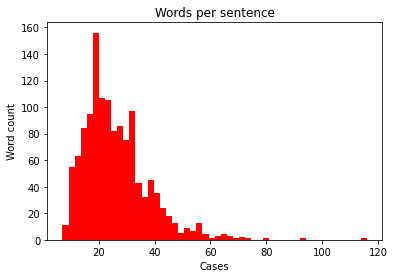

In [152]:
#Count words per sentence so we can set an appropiate max_len. In this case, 200 will be more than enough.
word_list = [len(x.split()) for x in df["clean_text"].tolist()]
fig = plt.figure()
ax = fig.add_subplot(1,1,1,)
n, bins, patches = ax.hist(word_list, bins=50, histtype='bar')

#ax.set_xticklabels([n], rotation='vertical')

for patch in patches:
    patch.set_facecolor('r')

plt.title("Words per sentence")
plt.xlabel('Cases')
plt.ylabel('Word count')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


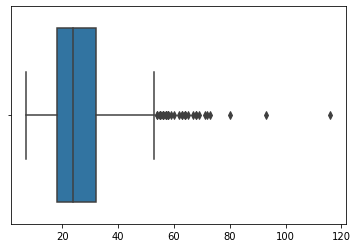

In [153]:
sns.boxplot(word_list)

In [154]:
np.count_nonzero(np.array(word_list) >= 75)
#maximum length of 75 is fine!

#recheck this after removing start-cite, end-cite etc

3

# Valentin tries with Keras

In [155]:
#lets turn "accept" into a column that properly lists the labels (right now it is a string of a list instead of a list of strings)
rejoined = np.array([row.split(" ") for row in df.labels_str])
df["accept"] = rejoined
df_new = df[["clean_text", "accept"]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [156]:
rejoined

array([list(['Data']), list(['Definition']), list(['Method', 'Theory']),
       ..., list(['Definition']), list(['RelationToLiterature']),
       list(['Definition'])], dtype=object)

In [157]:
df_new = df_new.reset_index().drop(columns = "index")
df_new.columns = ["text", "label"]

In [158]:
df_new.head()

,text,label
0,the other part of our data consists of an undirected social graph.,[Data]
1,this list of actors can be interpreted to represent the most important barriers to successful software development in nigeria.,[Definition]
2,"the two samples were compared on all study variables and on age, gender, position, and organizational tenure.","[Method, Theory]"
3,"this is supported by a more recent report by start_cite west and curtis (2006) end_cite cite_b72 , which found significant differences between women and men academics, including disparities in tenure and salaries.",[RelationToLiterature]
4,", the false noise parameter c was misstated by 0.10 (either all high or all low in a run) except near the end points (c = 0 or 1).",[Definition]


In [159]:
# First Split for Train and Test
#we should stratify, but we have some groups that have only one
train_df, test_df = train_test_split(df_new, test_size=0.3, random_state= 0)#, stratify = df_new.label.values)

# Next split test in to test and validation
val_df = test_df.sample(frac = 0.667)
test_df = test_df.drop(val_df.index)

#70% train, 20% val, 10% test
print(train_df.shape[0], val_df.shape[0], test_df.shape[0])

897 257 128


In [160]:
#encoding labels with keras Lookup Layer
terms = tf.ragged.constant(df_new["label"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)

print(f"Vocabulary: {vocab}")
#the UNK token will always also be returned.

Vocabulary: ['[UNK]', 'RelationToLiterature', 'Theory', 'Method', 'EmpiricalResult', 'Definition', 'Contribution', 'Motivation', 'Data', 'HypothesisResult', 'Goal', 'Limitation', 'FutureWork', 'Item', 'Hypothesis', 'ResearchQuestion']


In [161]:
#Example
sample_label = df_new["label"].iloc[2]
label_binarized = lookup([sample_label])
label_binarized, sample_label
#Note: Unlike the OHE with sklearn, this is not ordered alphabetically but in the order we can find below (including the UNK token)

(<tf.Tensor: shape=(1, 16), dtype=float32, numpy=
 array([[0.000000, 0.000000, 1.000000, 1.000000, 0.000000, 0.000000,
         0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
         0.000000, 0.000000, 0.000000, 0.000000]], dtype=float32)>,
 ['Method', 'Theory'])

Inspo:
 
https://www.kaggle.com/code/samarthagarwal23/0-81-tf-keras-deberta-baseline-single-model

https://keras.io/examples/nlp/multi_label_classification/ 

In [162]:
#Our Config (so we can reference this values in later code and avoid spaghetti)
seed = 0
epochs = 4 ##
#num_folds = 5, #set folds later on
max_length = 75
batch_size = 8
learning_rate = 3e-5 ## lower l r higher epoch
base_model = "bert-large-uncased" ##

In [163]:
#Prepare tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model)
def tok(x): return tokenizer(x, padding = True, truncation = True, return_tensors = "tf", max_length = max_length)

In [164]:
def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["label"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        #because tokenizing becomes more dificult afterwards (hugginface clashes a little with keras), I already tokenize here
        ((tok(list(dataframe.text))["input_ids"], tok(list(dataframe.text))["attention_mask"])
        #not using the token type since we are not using special tokens anyways
        ,label_binarized)
    )
    #take batches randomly along the whole dataset
    dataset = dataset.shuffle(batch_size * ((dataframe.shape[0] // batch_size) + 1)) if is_train else dataset
    return dataset.batch(batch_size)

In [165]:
#get datasets
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [166]:
test_dataset

<BatchDataset element_spec=((TensorSpec(shape=(None, 75), dtype=tf.int32, name=None), TensorSpec(shape=(None, 75), dtype=tf.int32, name=None)), TensorSpec(shape=(None, 16), dtype=tf.float32, name=None))>

In [167]:
def get_labels_out(dataset):
    labels = []
    for element in dataset:
        for arr in element[1]:
            labels.append(np.array(arr))
    labels = np.asarray(labels)
    return labels

In [168]:
#One example input and (decoded) output from the train dataset
text_batch, label_batch = next(iter(train_dataset))
for i, text in enumerate(text_batch[0][:3]):
    label = label_batch[i].numpy()
    print(f"Tokens: {text}")
    print(f"Label(s): {invert_multi_hot(label)}")
#the first three will be our input

Tokens: [  101  2947  1010  4642  2497  1011 10426 16902  2015  2090  1996 10857
  2104  4812  2024 10174  2011  7704  2989  2041  1996 10197  1997  4642
  2497  2013  1996  2434 16902  2015  2478  1996  2206  8522  2707  1035
 21893  1006 15451 12326  2527  3802  2632  1012  1010  2294  1007  2203
  1035 21893 21893  1035  1038 21084  1024   102     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
Label(s): ['RelationToLiterature' 'EmpiricalResult' 'Motivation']
Tokens: [  101  2004  2019  5665 19966 18514  2742  1010  2065 10390  2024 24854
  1999  2037  8192  6165  1010  2119  1996  3813  1998  1996 10390  2024
  3227  4788  2125  2007  1996  4443  1997  1052  2475  2361 12635  2015
  1012   102     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
La

In [169]:
"""#Val try
def build_model():
    
    input_ids = tf.keras.Input(shape=(max_length, ), dtype = tf.int32)
    input_mask = tf.keras.Input(shape=(max_length, ), dtype = tf.int32)
    
    bert = transformers.TFAutoModel.from_pretrained(base_model, num_labels=15, problem_type="multi_label", trainable=True)
    x = bert(input_ids = input_ids, attention_mask = input_mask)

    #this is for finetuning (tinkering with last layers)
    x = tf.keras.layers.GlobalAveragePooling1D()(x.last_hidden_state)
    x = tf.keras.layers.Dropout(0.1)(x) ############ 
    fnl = tf.keras.layers.Dense(lookup.vocabulary_size(), activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs = [input_ids, input_mask], 
                           outputs = fnl)
    return model"""

'#Val try\ndef build_model():\n    \n    input_ids = tf.keras.Input(shape=(max_length, ), dtype = tf.int32)\n    input_mask = tf.keras.Input(shape=(max_length, ), dtype = tf.int32)\n    \n    bert = transformers.TFAutoModel.from_pretrained(base_model, num_labels=15, problem_type="multi_label", trainable=True)\n    x = bert(input_ids = input_ids, attention_mask = input_mask)\n\n    #this is for finetuning (tinkering with last layers)\n    x = tf.keras.layers.GlobalAveragePooling1D()(x.last_hidden_state)\n    x = tf.keras.layers.Dropout(0.1)(x) ############ \n    fnl = tf.keras.layers.Dense(lookup.vocabulary_size(), activation=\'sigmoid\')(x)\n    \n    model = tf.keras.Model(inputs = [input_ids, input_mask], \n                           outputs = fnl)\n    return model'

In [173]:
#1st try Roger
def build_model():
    
    input_ids = tf.keras.Input(shape=(max_length, ), dtype = tf.int32)
    input_mask = tf.keras.Input(shape=(max_length, ), dtype = tf.int32)
    
    bert = transformers.TFAutoModel.from_pretrained(base_model, num_labels=15, problem_type="multi_label", trainable=True)
    x = bert(input_ids = input_ids, attention_mask = input_mask)

    #this is for finetuning (tinkering with last layers)
    x = tf.keras.layers.GlobalAveragePooling1D()(x.last_hidden_state)
    x = tf.keras.layers.Dropout(0.2)(x)
    fnl = tf.keras.layers.Dense(lookup.vocabulary_size(), activation='softmax')(x) #####
    
    model = tf.keras.Model(inputs = [input_ids, input_mask], 
                           outputs = fnl)
    return model

In [174]:
model = build_model()
model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
        loss = "binary_crossentropy", ########################
        metrics=["categorical_accuracy"], #### adjust metric for threshold
    )

ResourceExhaustedError: ignored

In [ ]:
callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', 
                                               patience=2,
                                               mode='max', 
                                               verbose=1,
                                               restore_best_weights=True)
callback_save = tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/Othercomputers/Mi portátil/Master/GitHub/twsm-group-project/keras_model/RogerSentenceBert2_LossSparse.h5', monitor='val_categorical_accuracy',  #save model in drive(github) #change name
        verbose=1, save_best_only=True,
        save_weights_only=True, mode='max', 
        save_freq='epoch')

In [ ]:
model.fit(train_dataset, 
        epochs = 10,
        shuffle=True,
        callbacks = [#callback_lr,,
                      callback_es,
                      callback_save,
                     ],
        batch_size = 8,
        validation_data= validation_dataset
       )
#Note: Bert-Base (used to set up the trainer) early stopped after 7 epochs with a max val_acc of 47%
#Roger 1st approach: dropout 0.2 activation: softmax = 51,75%
#Roger 2st approach: dropout 0.1 = 49%


In [ ]:
print(model.summary())

In [ ]:
preds = model.predict(test_dataset)
#preds[preds>=0.5] = 1
#preds[preds<0.5] = 0

In [ ]:
test_labels = get_labels_out(test_dataset)

In [ ]:

np.set_printoptions(formatter={'float_kind':'{:f}'.format})


for i, labels in enumerate(test_labels[:5]):
    print(f"index {i}: \n predictions: \n {preds[i]} \n real labels: \n {test_labels[i]}")


#with bert base:
#0 is perfect
#1 has a too low threshold (max is on right index but only at .39)
#2 did a bad prediction (low values for real values and very high for a different one)
#3 is perfect (with label "2" being kind of high with .22 (although it should be 0))
#4 only identified one of two labels (label "9" has value .22 (although it should be 1))

#with bert large:
#0 is just short of threshold
#1 only spotted one of the 3 labels, one label has high values (0.3) although it should be 0
#2 is perfeect
#3 is perfect
#4 did really bad, seems unsure between 6 labels, real label has low value (.17)

# Inference

# Retrain with new params

# Re-Inference